<div style="text-align: left">INFO 6105 Data Science Engineering Methods and Tools</div>
<div style="text-align: left">Assignment 9 Group 5</div>
<div style="text-align: left">Shashank Dongre (002747740)</div>
<div style="text-align: left"> Asawari Kadam (002711195)</div>

#### Question 1: Repeat your experiment with MOM on a single-humped dataset but with MLE instead!

##### First, let us take a look at our data set and plot its histogram, and find its MoM


In [314]:
# importing required libraries as follows: 
# Lets read the dataset using read_csv API
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
fuel_con = pd.read_csv("C:\\Users\\shash\\Downloads\\Fuel_Consumption_2000-2022.csv")
fuel_con.head(3)

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230


In [315]:
# Renaming the column of our interest. Here, we are interested in the fuel consumption of the cars per 100 km
fuel_con.rename(columns = {'HWY (L/100 km)':'HWY'}, inplace = True)
fuel_con.head(2)

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY,COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175


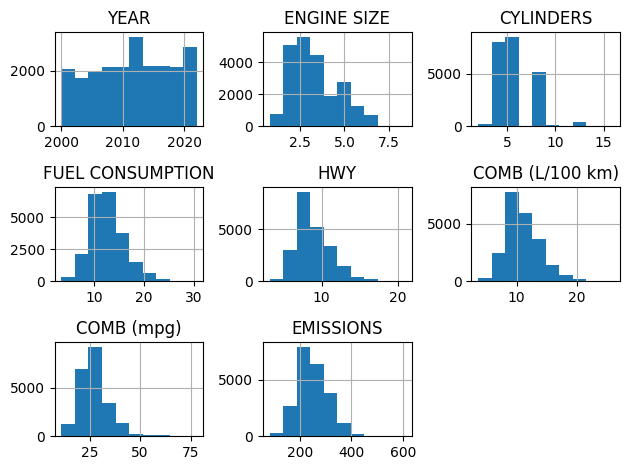

In [316]:
# Let us view the histogram of the dataset and all its parameters 
# the tight_layout automatically adjust subplot parameters to give specified padding which enables proper fitting
fuel_con.hist()
plt.tight_layout()

<AxesSubplot: >

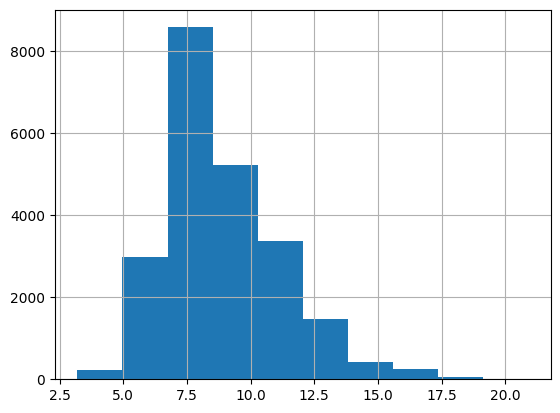

In [317]:
# Let us look at the histogram of HWY column
fuel_con.HWY.hist()

In [318]:
# Calculating mean of every column in the dataset 
fuel_con_mean = fuel_con.select_dtypes(include=np.number).mean()
fuel_con_mean

YEAR                2011.554442
ENGINE SIZE            3.356646
CYLINDERS              5.854141
FUEL CONSUMPTION      12.763513
HWY                    8.919126
COMB (L/100 km)       11.034341
COMB (mpg)            27.374534
EMISSIONS            250.068452
dtype: float64

In [319]:
# Calculating variance of every column in the dataset 
fuel_con_var = fuel_con.select_dtypes(include=np.number).var()
fuel_con_var

YEAR                  39.668195
ENGINE SIZE            1.783360
CYLINDERS              3.310934
FUEL CONSUMPTION      12.256993
HWY                    5.174551
COMB (L/100 km)        8.473455
COMB (mpg)            54.419860
EMISSIONS           3523.048828
dtype: float64

The method of moments simply assigns the empirical (coming from the data) mean and variance to their theoretical counterparts (coming from the model, in this case the Gamma!), so that we can solve for the parameters of the Gamma!

So, for the gamma distribution, the mean and variance turn out to be (analytically derived):


In [320]:
alpha_mom = fuel_con_mean ** 2 / fuel_con_var
beta_mom = fuel_con_var / fuel_con_mean
alpha_mom

YEAR                102004.924704
ENGINE SIZE              6.317887
CYLINDERS               10.350844
FUEL CONSUMPTION        13.290965
HWY                     15.373471
COMB (L/100 km)         14.369190
COMB (mpg)              13.770067
EMISSIONS               17.750032
dtype: float64

In [321]:
beta_mom

YEAR                 0.019720
ENGINE SIZE          0.531292
CYLINDERS            0.565571
FUEL CONSUMPTION     0.960315
HWY                  0.580163
COMB (L/100 km)      0.767917
COMB (mpg)           1.987974
EMISSIONS           14.088338
dtype: float64

Then, use the gamma.pdf function in scipy.stats.distributions to plot the MoM distribution implied by the calculated alphas and betas. We select alpha_mom[-4] and beta_mom[-4] because HWY is the fourth column from the end.

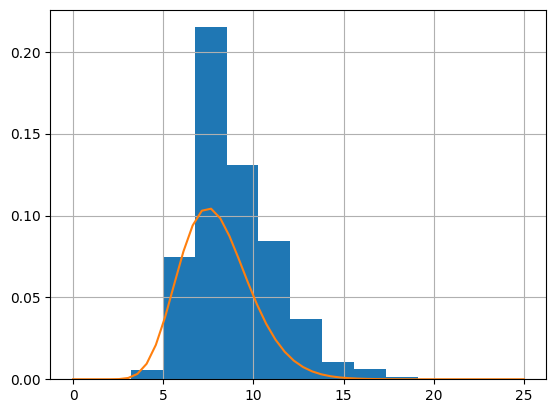

In [322]:
from scipy.stats.distributions import gamma

fuel_con.HWY.hist(density=True, bins=10)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 50), alpha_mom[-4], beta_mom[-4]))

In [323]:
from scipy.optimize import newton

Let us put MLE to use now, we start with 
$$l = \prod_{i=1}^n \beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}$$ with respect to $(\alpha, \beta)$

In order to make the likelihood function more manageable (this is legit since `log` is monotonic with respect to its argument), the optimization is performed ***using a natural log transformation of the likelihood function***. In other words, we apply a **kernel method** transformation, which we learned about in our previous notebook. 

We are going to use the property that the *log of a product is the sum of the logs*:

$$ log(ab) = log(a) + log(b)$$

We want to maximize:

$$\begin{align}log(l)(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

where

$$\bar{x} = \frac{\sum_i{x_i}}{n}$$

here n = 2022-2000=22 and the bar indicates an average over all *i*. We want to choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

## 3.5 Solving the equation

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial log(l)(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha\; / \; \bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial log(l)(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\partial log(\Gamma(\alpha))}{\partial\alpha} = 0$$

This has ***no closed form solution***! We must use ***numerical optimization***!

Numerical optimization algorithms take an initial "*guess*" at the solution, and iteratively improves the guess until it gets "*close enough*" to the answer.

Here, we will use [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) algorithm from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html):

<div style="font-size: 120%;">  
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$
</div>

Here is a graphical example of how Newton-Raphson converges on a solution: what is the $x$ for which  $f(x) = 0$, using derivatives:

Text(1.4706070287539936, -0.2, '$x_{n+1}$')

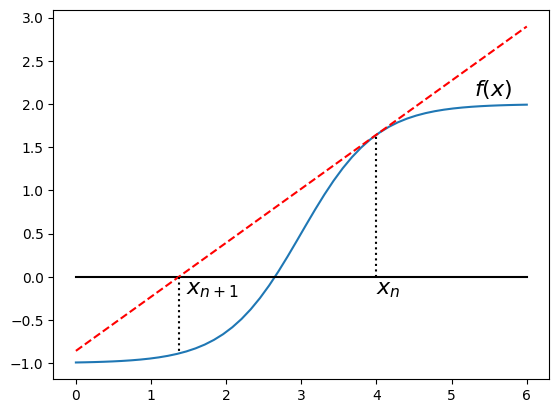

In [324]:
# some function
func = lambda x: 3./(1 + 400*np.exp(-2*x)) - 1
xvals = np.linspace(0, 6)
plt.plot(xvals, func(xvals))
plt.text(5.3, 2.1, '$f(x)$', fontsize=16)

# zero line
plt.plot([0,6], [0,0], 'k-')

# value at step n
plt.plot([4,4], [0,func(4)], 'k:')
plt.text(4, -.2, '$x_n$', fontsize=16)

# tangent line
tanline = lambda x: -0.858 + 0.626*x
plt.plot(xvals, tanline(xvals), 'r--')

# point at step n+1
xprime = 0.858/0.626
plt.plot([xprime, xprime], [tanline(xprime), func(xprime)], 'k:')
plt.text(xprime+.1, -.2, '$x_{n+1}$', fontsize=16)

In [325]:
from scipy.special import psi, polygamma

In [326]:
# We first define a function for exception handling. 
# if an exception occurs (i.e., if x is not a valid input for the "log" function), the function will return NaN (not a number) 
# using the numpy library's "nan" function.

def safe_log(x):
    try:
        return np.log(x)
    except:
        return np.nan


The dlgamma function takes three parameters m, log_mean, and mean_log. It returns the value of the log-derivative of the gamma function at m.

The dl2gamma function takes a variable number of parameters, with m being the first parameter. It calculates the second derivative of the log of the gamma function at m.

We use psi() for the digamma function, polygamma() for the trigamma function, and np.log() for the natural logarithm. 

In [327]:
# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [328]:
# Let us calculate statistics
# log_mean is used to calculate the natural logarithm of the mean value for each numeric column in the fuel_con dataframe. 
# 'select_dtypes' method is used to filter the columns based on their data type, mean for calculating mean, 
# and apply method to apply the safe_log function 

log_mean = fuel_con.select_dtypes(include=np.number).mean().apply(safe_log)
log_mean



YEAR                7.606663
ENGINE SIZE         1.210942
CYLINDERS           1.767149
FUEL CONSUMPTION    2.546591
HWY                 2.188198
COMB (L/100 km)     2.401012
COMB (mpg)          3.309613
EMISSIONS           5.521735
dtype: float64

In [329]:
# Now, we calculate the mean of the natural logarithm of each element in the fuel_con dataframe.
mean_log = fuel_con.apply(safe_log).mean()
mean_log


YEAR                7.606658
MAKE                     NaN
MODEL                    NaN
VEHICLE CLASS            NaN
ENGINE SIZE         1.131797
CYLINDERS           1.721578
TRANSMISSION             NaN
FUEL                     NaN
FUEL CONSUMPTION    2.509422
HWY                 2.157602
COMB (L/100 km)     2.367338
COMB (mpg)          3.275512
EMISSIONS           5.493425
dtype: float64

We now use the newton function to compute the maximum likelihood estimate (MLE) of the shape parameter alpha for the gamma distribution of the HWY column in the fuel_con dataframe. The newton function uses the Newton-Raphson method to find the root of a scalar function. The newton function starts with an initial guess of 2 for the shape parameter m, and iteratively refines this estimate until the scalar function is minimized. We are using maximum likelihood estimation to find the best-fitting shape parameter for the gamma distribution of the HWY column in the fuel_con dataframe, based on the observed data.


In [330]:
# Alpha MLE for HWY
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-4], mean_log[-4]))
alpha_mle

16.50701114209817

In [331]:
# Beta MLE for HWY (best fitting scale parameter beta)
beta_mle = alpha_mle/fuel_con.select_dtypes(include=np.number).mean()[-4]
beta_mle

1.8507431825718406

In [332]:
# Fuel Consumption mean for HWY
fuel_con_mean = fuel_con.select_dtypes(include=np.number).mean()[-4]
fuel_con_mean



8.919125731512679

In [333]:
# Fuel Consumption variance for HWY
fuel_con_var = fuel_con.select_dtypes(include=np.number).var()[-4]
fuel_con_var



5.174550616689223

In [334]:
# Recalling the previously calculated alpha_mom
alpha_mom = fuel_con_mean ** 2 / fuel_con_var
alpha_mom


15.373470994362348

In [335]:
# Recalling the previously calculated beta_mom
beta_mom = fuel_con_var / fuel_con_mean
beta_mom


0.5801634344503878

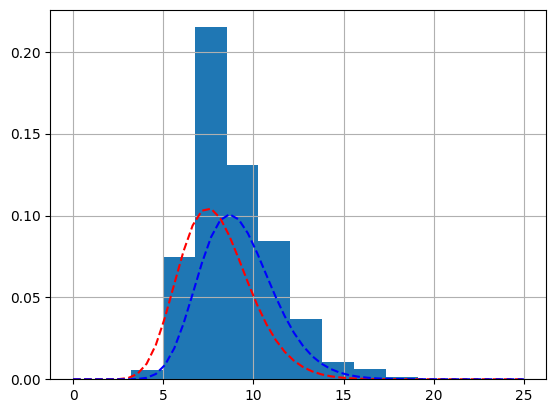

In [336]:
# Plotting both models and comparing. We are using red color for plotting the gamma distribution model for mom and 
# blue color for plotting the gamma distribution model for mle. 
# In other words, The red dashed line represents the model estimated using the method of moments, 
# while the blue dashed line represents the model estimated using maximum likelihood estimation.

from scipy.stats.distributions import gamma
fuel_con.HWY.hist(density=True, bins=10)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 50), alpha_mom, beta_mom), 'r--')
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 50), alpha_mle, beta_mle), 'b--')


As we can see from the graph above, the model estimated using maximum likelihood estimation (blue) is more closely fitting the data when compared with the model estimated using the method of moments (red). This indicates that maximum likelihood estimation is a better model in this case when compared with Method of Moments.

 We are now using the gamma.fit function from the scipy.stats module to estimate the shape and scale parameters of a gamma distribution that best match the data in the HWY column of the fuel_con dataframe using MLE. 

In [337]:
from scipy.stats import gamma

gamma.fit(fuel_con.HWY)

(7.313488931442757, 2.8927250961932542, 0.8240123112986044)

The estimated gamma distribution has a shape parameter (alpha) of 7.31, a scale parameter (beta) of 2.89, and a location parameter (loc) of     0.82. These resultant parameters are different from the ones we obtained because of different numerical optimization algorithms or some other factors.